In [5]:
%pylab inline
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [ ]:
# X_train: training images
# Y_train: training labels
# X_test: Test images
# Y_test: test labels

# reshapes data into format where each image is 28x28 pixels
# flatten 2D images in to 1D arrays, with 784 columns
# 60000 as number of images in dataset 748 = 28*28
X_train.reshape(-1, 28*28).shape

(<matplotlib.image.AxesImage at 0x11f222f10>, 0)

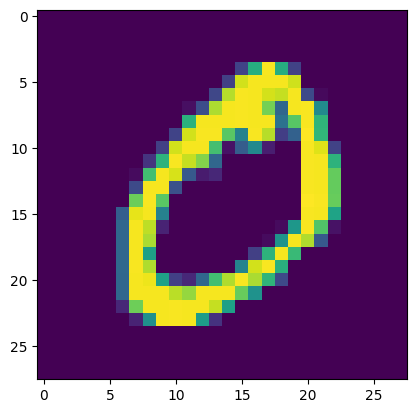

In [6]:
imshow(X_train[1]), Y_train[1]

In [41]:
# model in pytorch
import torch
import torch.nn as nn

# implement in pytorch
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.act = nn.ReLU()
    self.l2 = nn.Linear(128,10)
  def forward(self,x):
    x = self.l1(x)
    x = self.act(x)
    x = self.l2(x)
    return x
model = BobNet()

In [10]:
X_train.shape

(60000, 28, 28)

In [24]:
# don't be a noob
s = X_train[0:10].reshape(-1,28*28)
float_tensor = torch.tensor(s).float()
mo = model(float_tensor)

In [12]:
np.random.randint(0,100, size=32)

array([64, 38,  1, 71, 71, 56, 58, 10, 28,  6, 83, 24, 54, 51, 44, 48, 59,
       46, 24, 78, 80, 93, 14, 45, 86, 45, 14,  8, 45, 89, 68, 32])

loss 0.35 accuracy 0.94: 100%|██████████| 1000/1000 [00:00<00:00, 1014.54it/s]


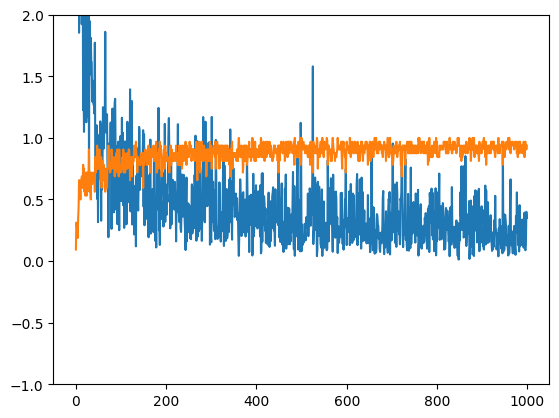

In [42]:
# quick training loop model
BS = 32
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
# what's SGD? what's learning rate?

losses, accuracies = [], []

for i in (t:= trange(1000)):
  samp = np.random.randint(0,X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  optim.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat==Y).float().mean()
  # crossentropyloss class?
  loss = loss_func(out, Y)
  # back propagation
  loss.backward()
  # torch optimizer? adam?
  # updates the weights of the neural network to minimize the loss function
  # adam is automatically adjusts the learning rate during training and often performs well in practice
  # zero_grad. george forgot to do that in 1 of example lol
  optim.step()

  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)

  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-1,2)
plot(losses)
plot(accuracies)

In [43]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9201

# From Scratch!
Goal is to have the same result as pytorch

In [59]:
# init the network
# what's linear layer? what's relu?
# why float32?
# why twist the shape?
l1 = np.zeros((128,784), dtype=np.float32)
l2 = np.zeros((10, 128), dtype=np.float32)

l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 11141011216, 11025597136)

In [49]:
model.l1.weight

Parameter containing:
tensor([[-0.0059, -0.0174,  0.0017,  ...,  0.0263, -0.0277, -0.0161],
        [-0.0201, -0.0193, -0.0193,  ..., -0.0159,  0.0002, -0.0272],
        [ 0.0002,  0.0169,  0.0330,  ..., -0.0100,  0.0289, -0.0309],
        ...,
        [ 0.0211,  0.0047, -0.0135,  ...,  0.0346, -0.0324, -0.0252],
        [ 0.0093,  0.0272,  0.0174,  ...,  0.0261,  0.0020, -0.0208],
        [ 0.0321, -0.0208, -0.0052,  ...,  0.0026, -0.0111,  0.0353]],
       requires_grad=True)

In [61]:
# copy weights from pytorch

l1[:] = model.l1.weight.detach().numpy()
l2[:] = model.l2.weight.detach().numpy()

In [67]:
# numpy forward pass
def forward(x):
    x = x.dot(l1.T)
    x = np.maximum(x, 0)
    x = x.dot(l2.T)
    return x
    
Y_tset_preds = np.argmax(forward(X_test[0:10].reshape((-1,28*28))), axis=1)
(Y_test == Y_test_preds).mean()

0.9201

In [ ]:
# training in numpy
